<a href="https://colab.research.google.com/github/mateusnotgado/COVID/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 Predição de Risco de Mortalidade - COVID-19 (Recife/PE)

Este notebook apresenta o desenvolvimento de um modelo de Machine Learning focado em identificar o risco de óbito no momento da notificação de pacientes com Síndrome Respiratória Aguda Grave.

### ❓ Pergunta de Pesquisa
> **"Quais preditores clínicos presentes no momento da notificação são determinantes para a predição do risco de mortalidade em pacientes com Covid-19?"**

---

### 📚 Referências e Protocolos
A base lógica para as decisões tomadas se baseiam nas analises dos dados e no que consta nas diretrizes oficiais:
* [Guia de Orientações para Profissionais de Saúde - SRAG 2025 (Ministério da Saúde)](https://www.gov.br/saude/pt-br/centrais-de-conteudo/publicacoes/guias-e-manuais/2025/guia-de-orientacoes-para-profissionais-de-saude-srag.pdf)

### 📊 Fontes de Dados
Os dados utilizados são provenientes da Secretaria de Saúde de Recife, do ano de 2022 abrangendo:
* [Dataset: Casos Graves](http://dados.recife.pe.gov.br/dataset/casos-graves-covid-19)
* [Dataset: Casos Leves](http://dados.recife.pe.gov.br/pt_BR/dataset/casos-leves-covid-19)

---
### 🛠️ Metodologia e Workflow
O projeto foi dividido em cinco etapas fundamentais:

1. **Extração:** Extração das bases e as libs do projeto.
2. **Limpeza e engenharia:** tratamento de valores faltantes, seleção de colunas relevantes, tratamento da coluna sintomas que era uma lista de strings para uma var binaria por sintoma, permitindo, assim, que o modelo avalie o impacto de cada sintoma individualmente, extração extra de sintomas de uma coluna secundaria de sintomas usando regex e tratamento de janelas temporais e seus outliers.
3. **Análise Exploratória (EDA):** avaliando variaveis com vizualizações e validação estatística (Chi-Quadrado),para identificar padrões de letalidade.
4. **Modelagem:** Experimentos com Random Forest e XGBoost com ajuste de hiperparâmetros via Optuna focando na maximização do *Recall*.
5. **Conclusões**: análise de insights,performance dos modelos, trade-offs e limitações do projeto

#Extração

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

from xgboost import XGBClassifier

import optuna

import re

import joblib

In [3]:
url_graves = 'http://dados.recife.pe.gov.br/dataset/2b5ee58d-9535-4d80-ab32-f63fd475346e/resource/93f4e8c2-430f-4142-86b3-96dab4905b4e/download/casosgravescovid.csv'
url_leves='http://dados.recife.pe.gov.br/dataset/35b7d449-f2f5-4d90-a1ed-6d2a23462bc8/resource/aef78843-997a-4079-8583-b95c1cc2d05f/download/casoslevescovid2022.csv'

In [ ]:
df_graves= pd.read_csv(url_graves, sep=';')
df_leves= pd.read_csv(url_leves, sep=';')

#Limpeza e engenharia

Variáveis de ocupação e localidade foram excluídas do modelo preditivo por refletirem predominantemente aspectos de acesso ao sistema de saúde e contexto socioinstitucional, e não características clínicas intrínsecas do paciente

As informações sobre comorbidades estavam disponíveis exclusivamente no dataset de Casos Graves. Optou-se pela remoção dessas variáveis para evitar o Vazamento de Dados (Data Leakage) Estrutural.

Como o dataset de Casos Leves não possuía o registro de comorbidades (campos nulos/vazios), a manutenção dessas colunas criaria um viés onde o modelo aprenderia que a ausência de informação é sinônimo de um caso leve. Na prática, o modelo passaria a prever a origem do dado (dataset A ou B) em vez do risco clínico real do paciente.

Se mativer a coluna de comorbidades, os dados ficaram assim, por exemplo :

obs : ( supondo que as unicas comorbidades existentes sejam diabetes e obesidade)


| Paciente | OBESIDADE | DIABETES | CASO GRAVE
| ----------- | ----------- | ----------- |----------- |
| x1 | 1 | 0 |1 |
| x2 | 1 | 1 |1 |
| x3 | 0 | 0 |0 |
| x4 | 0 | 0 |0 |
| x5 | 0 | 0 |0 |
| x6 | 0 | 1 |1 |

com isso os modelos iriam aprender que casos leves-> falta de comorbidades, o que não é o caso

## Dataset de casos graves

### Removendo colunas

In [74]:
df_graves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36435 entries, 0 to 36434
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   data_notificacao               36435 non-null  object
 1   sexo                           36435 non-null  object
 2   raca                           30106 non-null  object
 3   etnia                          4 non-null      object
 4   idade                          36435 non-null  object
 5   municipio_residencia           36435 non-null  object
 6   bairro                         36435 non-null  object
 7   distrito_sanitario             36435 non-null  object
 8   data_inicio_sintomas           36435 non-null  object
 9   sintomas                       34477 non-null  object
 10  outros_sintomas                5974 non-null   object
 11  doencas_preexistentes          13698 non-null  object
 12  outras_doencas_preexistentes   7807 non-null   object
 13  p

In [75]:
pct_nulls = df_graves.isna().mean() * 100
pct_nulls

,0
data_notificacao,0.000000
sexo,0.000000
raca,17.370660
etnia,99.989022
idade,0.000000
municipio_residencia,0.000000
bairro,0.000000
distrito_sanitario,0.000000
data_inicio_sintomas,0.000000
sintomas,5.373954


irei remover as variaveis `etnia` e `outros_sintomas` pela alta quantidade de nulls.

In [76]:
cols_to_drop = ['etnia', 'categoria_profissional', 'municipio_residencia','bairro','distrito_sanitario'
,'data_obito','outros_sintomas','profissional_saude','doencas_preexistentes', 'outras_doencas_preexistentes ']
df_graves.drop(columns=cols_to_drop, inplace=True,errors='ignore')

### Tratando colunas




In [77]:
# passar coluna de idade para int
df_graves['idade'] = pd.to_numeric(df_graves['idade'], errors='coerce')

In [78]:
#corrigindo valores para sincronizar com o outro dataset
df_graves['raca']=df_graves['raca'].replace('Indígena','Indigena')

In [79]:
# essas variaveis do jeito que estão, não fornecem informação útil,
# por isso será extraido intervalo de tempo em dias do inicio dos sintomas até a notificação

#convertendo os tipos para date
df_graves['data_notificacao'] = pd.to_datetime(df_graves['data_notificacao'])
df_graves['data_inicio_sintomas'] = pd.to_datetime(df_graves['data_inicio_sintomas'])

# 2. Calcular a diferença e extrair apenas o número de dias (.dt.days)
df_graves['dias_ate_notificar'] = (df_graves['data_notificacao'] - df_graves['data_inicio_sintomas']).dt.days

# 3. Remover as colunas originais
df_graves.drop(columns=['data_notificacao', 'data_inicio_sintomas'], inplace=True)

In [80]:
df_graves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36435 entries, 0 to 36434
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sexo                 36435 non-null  object 
 1   raca                 30106 non-null  object 
 2   idade                35482 non-null  float64
 3   sintomas             34477 non-null  object 
 4   classificacao_final  36435 non-null  object 
 5   evolucao             35458 non-null  object 
 6   dias_ate_notificar   36435 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 1.9+ MB


### Tratando os nulls

In [81]:
# Decisão técnica: Preenchimento como 'Ignorado'
# Justificativa: Dado o volume de 17% de nulos e o potencial viés de seleção em dados de saúde,
# optou-se por tratar o dado faltante como uma categoria própria. Isso evita a diluição de informaçoes sobre
# padrões biológicos entre raças e de desigualdade social e permite ao modelo captar possíveis correlações entre a qualidade
# do preenchimento da ficha e o desfecho clínico.
# Isso é evidenciado pela escolha de features do modelo, a var 'ignorado' (var binaria pos transformação em formato one hot encode)
# foi uma das principais do modelo escolhido
#o que indica que a falta de dados na coluna raça contém informação útil e que não está faltando aleatoriamente
# e caso eu tivesse optado por preencher com moda, não seria nessa etapa para evitar data leakage
df_graves['raca'] = df_graves['raca'].fillna('Ignorado')

In [82]:
# evolucao é a variavel que queremos prever, valores nulls não servem
# sintomas é variavel central para predição, se não for informado, só irá gerar vies pela falta
df_graves=df_graves.dropna(subset=['evolucao','sintomas'])


idade ainda possui valores null, mas para evitar data leakage, ela permanecera assim até que se separe os folds quando for usar cross validation, onde ela serã prenchida com a mediana para cada fold isoladamente, dentro de um pipeline

In [83]:
pct_nulls = df_graves.isna().mean() * 100
pct_nulls

,0
sexo,0.000000
raca,0.000000
idade,2.640992
sintomas,0.000000
classificacao_final,0.000000
evolucao,0.000000
dias_ate_notificar,0.000000


### Tratando a coluna sintomas



A coluna original de sintomas apresentava listas de strings (ex: `"Febre, Tosse, Dispneia"`). O tratamento direto por *One-Hot Encoding* convencional seria ineficaz, pois criaria categorias para cada **combinação única**, impedindo o modelo de entender a sobreposição de sintomas entre pacientes.


Se tratássemos a lista inteira como uma única categoria, o modelo veria os pacientes abaixo como totalmente distintos:

| Paciente | Sintomas Originais | Vetor One-Hot (Incorreto) |
| :--- | :--- | :--- |
| **João** | Febre, Tosse, Coriza, Vomito | `[1, 0, 0]` |
| **Marcos** | Febre, Tosse, Coriza, Vomito, Cefaleia | `[0, 1, 0]` |
| **Lucas** | Saturação < 95, Dispneia | `[0, 0, 1]` |

> **Falha:** Matematicamente, a distância entre João e Marcos seria a mesma que entre João e Lucas, ignorando que os dois primeiros compartilham 4 sintomas clínicos.

***A Solução Aplicada: Binarização Individual***

Expandimos cada sintoma para sua própria coluna binária. Isso permite que o modelo avalie o peso individual de cada preditor clínico e compare a similaridade real entre os indivíduos:

| Paciente | Febre | Tosse | Coriza | Vomito | Cefaleia | Sat < 95 | Dispneia |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **João** | 1 | 1 | 1 | 1 | 0 | 0 | 0 |
| **Marcos** | 1 | 1 | 1 | 1 | 1 | 0 | 0 |
| **Lucas** | 0 | 0 | 0 | 0 | 0 | 1 | 1 |

>**Resultado:** O modelo agora identifica que `Saturação < 95` e `Dispneia` são preditores críticos de mortalidade, independentemente de estarem acompanhados por sintomas leves como `Cefaleia`.

In [ ]:
# cada linha é uma string de sintomas dividos por ',' por ex : 'febre,tosse,coriza...'
# primiro se extrai os termos explitando por ',' e colocando num set python para pegar os valores unicos
# aqui não é preciso tratar, os dados dessa coluna estão bem padronizados
sintomas = set()
for row in df_graves['sintomas']:
  if pd.notna(row):
    sintomas.update(row.split(','))
cleaned_sintomas = {s.strip() for s in sintomas}

# Criar uma coluna binária para cada sintoma
for sintoma in cleaned_sintomas:
    # Usar str.contains com na=False para tratar NaN como False (0)
    df_graves[f'sintoma_{sintoma.replace(" ", "_").replace("/", "_")}'] = \
        df_graves['sintomas'].str.contains(sintoma, na=False).astype(int)

print("Colunas de sintomas binárias criadas. Exibindo as primeiras linhas com as novas colunas:")
display(df_graves.head())

In [85]:
df_graves.drop(columns=['sintomas'], inplace=True,errors='ignore')

## Dataset de casos leves

In [86]:
df_leves.head()

,sexo,data_notificacao,idade,data_inicio_sintomas,sintomas,outros_sintomas,classificacao_final,evolucao_caso,resultaado_final,etnia,raca_cor,profissional_saude,cbo,bairro,ds,municipio_residencia
0,Masculino,2022-06-21,1,2022-06-18,"Coriza, Tosse, Febre",0,NaN,NaN,NaN,NaN,Parda,Não,0,IBURA,VIII,Recife
1,Feminino,2022-02-02,65,2022-02-02,"Febre, Dor de Cabeça",0,NaN,NaN,NaN,NaN,Parda,Não,0,JIQUIA,V,Recife
2,Feminino,2022-06-14,47,2022-06-11,"Distúrbios Gustativos, Dor de Cabeça, Dor de G...",0,NaN,NaN,Negativo,NaN,Parda,Sim,Técnicos e auxiliares de enfermagem,DOIS IRMAOS,III,Recife
3,Masculino,2022-06-21,74,2022-06-14,"Tosse, Coriza",0,NaN,NaN,Negativo,NaN,Parda,Não,0,AREIAS,V,Recife
4,Feminino,2022-06-21,71,2022-06-21,Assintomático,0,NaN,NaN,NaN,NaN,Ignorado,Não,0,TORROES,IV,Recife


### Removendo colunas

avaliando % de nulls e nível de variancia, removendo colunas que não forneçam informação útil

In [87]:
df_leves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245956 entries, 0 to 245955
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   sexo                  245956 non-null  object
 1   data_notificacao      245956 non-null  object
 2   idade                 245956 non-null  object
 3   data_inicio_sintomas  245956 non-null  object
 4   sintomas              245956 non-null  object
 5   outros_sintomas       245956 non-null  object
 6   classificacao_final   104192 non-null  object
 7   evolucao_caso         104209 non-null  object
 8   resultaado_final      214456 non-null  object
 9   etnia                 72 non-null      object
 10  raca_cor              245955 non-null  object
 11  profissional_saude    245956 non-null  object
 12  cbo                   245956 non-null  object
 13  bairro                245956 non-null  object
 14  ds                    245956 non-null  object
 15  municipio_residen

In [88]:
pct_nulls = df_leves.isna().mean() * 100
pct_nulls

,0
sexo,0.000000
data_notificacao,0.000000
idade,0.000000
data_inicio_sintomas,0.000000
sintomas,0.000000
outros_sintomas,0.000000
classificacao_final,57.637952
evolucao_caso,57.631040
resultaado_final,12.807169
etnia,99.970726


a coluna `etnia` será descartada, por conter praticamente Nulls

0 foi usado para representar valores vazios, podemos trocar 0 por Nan e descobrir a % de nulls da coluna





In [89]:
df_leves['outros_sintomas'] = df_leves['outros_sintomas'].replace('0',np.nan)
df_leves['outros_sintomas'].isna().mean() * 100

np.float64(92.73894517718617)

mesmo com mais de 90% de valores nulos, `outros_sintomas` também será descartadonão será descartado, pois sintomas só registram os sintomas mais leves e veremos que outros_sintomaspossui registro dos sintomas mais graves. E considerando que os casos graves são menos de 10% do tamanho do dataset de leves, esses 8% pode fornecer quantidade util de informação para discriminar as 2 classes, quando sintomas mais severos aparecerem

In [90]:
cols_to_drop=['etnia','municipio_residencia','cbo','bairro','ds'
,'profissional_saude','resultaado_final']
df_leves=df_leves.drop(columns=cols_to_drop,errors='ignore')

In [91]:
df_leves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245956 entries, 0 to 245955
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   sexo                  245956 non-null  object
 1   data_notificacao      245956 non-null  object
 2   idade                 245956 non-null  object
 3   data_inicio_sintomas  245956 non-null  object
 4   sintomas              245956 non-null  object
 5   outros_sintomas       17859 non-null   object
 6   classificacao_final   104192 non-null  object
 7   evolucao_caso         104209 non-null  object
 8   raca_cor              245955 non-null  object
dtypes: object(9)
memory usage: 16.9+ MB


### Tratando colunas


In [92]:

# idade de texto -> numeric
df_leves['idade'] = pd.to_numeric(df_leves['idade'], errors='coerce')

In [93]:
df_leves = df_leves.rename(columns={"resultaado_final": "resultado_final"})
df_leves = df_leves.rename(columns={"evolucao_caso": "evolucao"})
df_leves = df_leves.rename(columns={"raca_cor": "raca"})

In [94]:
df_leves['data_notificacao'] = pd.to_datetime(df_leves['data_notificacao'])
df_leves['data_inicio_sintomas'] = pd.to_datetime(df_leves['data_inicio_sintomas'])

# 2. Calcular a diferença e extrair apenas o número de dias (.dt.days)
df_leves['dias_ate_notificar'] = (df_leves['data_notificacao'] - df_leves['data_inicio_sintomas']).dt.days

# 3. Remover as colunas originais
df_leves.drop(columns=['data_notificacao', 'data_inicio_sintomas'], inplace=True)

### tratando nulls

In [95]:
df_leves['raca']=df_leves['raca'].fillna('Ignorado')

In [96]:
# essa é a var que se quer prever, se estiver vazia/ingorado não tem serventia
df_leves = df_leves[df_leves['evolucao'].str.upper() != 'IGNORADO']

In [97]:
# essa é a var que se quer prever, se estiver vazia/ignorado não tem serventia

df_leves=df_leves.dropna(subset=['evolucao'])

### tratando coluna sintomas

mesma justificativa usado no tratamento da coluna sintomas do dataset de graves

In [98]:
sintomas = set()
for row in df_leves['sintomas']:
  if pd.notna(row):
    sintomas.update(row.split(','))
cleaned_sintomas = {s.strip() for s in sintomas}
cleaned_sintomas

{'Assintomático',
 'Coriza',
 'Dispneia',
 'Distúrbios Gustativos',
 'Distúrbios Olfativos',
 'Dor de Cabeça',
 'Dor de Garganta',
 'Febre',
 'Outros',
 'Tosse'}

In [99]:
# Criar uma coluna binária para cada sintoma
for sintoma in cleaned_sintomas:
    # Usar str.contains com na=False para tratar NaN como False (0)
    df_leves[f'sintoma_{sintoma.replace(" ", "_").replace("/", "_")}'] = \
        df_leves['sintomas'].str.contains(sintoma, na=False).astype(int)

print("Colunas de sintomas binárias criadas. Exibindo as primeiras linhas com as novas colunas:")
display(df_leves.head())

Colunas de sintomas binárias criadas. Exibindo as primeiras linhas com as novas colunas:


,sexo,idade,sintomas,outros_sintomas,classificacao_final,evolucao,raca,dias_ate_notificar,sintoma_Distúrbios_Olfativos,sintoma_Dor_de_Garganta,sintoma_Assintomático,sintoma_Tosse,sintoma_Distúrbios_Gustativos,sintoma_Dispneia,sintoma_Coriza,sintoma_Dor_de_Cabeça,sintoma_Outros,sintoma_Febre
39,Masculino,33.0,"Dor de Garganta, Coriza",NaN,Confirmado Laboratorial,Cura,Parda,4,0,1,0,0,0,0,1,0,0,0
75,Feminino,29.0,"Coriza, Distúrbios Olfativos",NaN,Confirmado Laboratorial,Cura,Parda,7,1,0,0,0,0,0,1,0,0,0
445,Feminino,52.0,Assintomático,NaN,Descartado,Cura,Branca,0,0,0,1,0,0,0,0,0,0,0
842,Feminino,28.0,"Coriza, Tosse, Dor de Garganta",NaN,Descartado,Cura,Ignorado,2,0,1,0,1,0,0,1,0,0,0
1544,Masculino,37.0,"Febre, Tosse",NaN,Confirmado Laboratorial,Em tratamento domiciliar,Branca,5,0,0,0,1,0,0,0,0,0,1


In [100]:
df_leves=df_leves.drop(columns=['sintomas'],errors='ignore')

## Merging datasets

juntando os datasets para melhor analise e modelagem

### Colunas de sintomas

Renomeando variaveis equivalentes

In [101]:
df_graves = df_graves.rename(columns={"sintoma_Coriza___Congestão_Nasal": "sintoma_Coriza"})
df_graves = df_graves.rename(columns={"sintoma_Cefaleia": "sintoma_Dor_de_Cabeça"})
df_graves = df_graves.rename(columns={"sintoma_Alteração_perda_de_olfato_e_ou_paladar": "sintoma_perda_sentidos"})


df_leves['sintoma_perda_sentidos'] = df_leves[['sintoma_Distúrbios_Olfativos', 'sintoma_Distúrbios_Gustativos']].max(axis=1)

df_leves=df_leves.drop(columns=['sintoma_Distúrbios_Olfativos', 'sintoma_Distúrbios_Gustativos'])


Para a harmonização dos datasets, realizou-se a recuperação de sintomas estruturados presentes na base de casos graves (SRAG), mas ausentes no formulário padrão de casos leves. Esses dados foram extraídos do campo de texto livre 'Outros Sintomas' por meio de processamento de texto com expressões regulares (Regex). Esta etapa foi fundamental para mitigar a esparsidade dos dados e garantir a simetria de atributos entre as bases, permitindo que sintomas críticos fossem representados em ambos os perfis de pacientes

In [102]:
df_graves.filter(like='sintoma_').sum().sort_values(ascending=False)

,0
sintoma_Tosse,25732
sintoma_Dispneia,23841
sintoma_Febre,22203
sintoma_Saturação_O2_<_95,17085
sintoma_Desconforto_respiratório___aperto_torácico,9984
sintoma_Dor_de_Garganta,5309
sintoma_Dor_de_Cabeça,4013
sintoma_Mialgia,3722
sintoma_Coriza,3249
sintoma_Diarreia,3128


In [103]:
'''
Como a frequência delas é mínima (menos de 1% no dataset de graves),
o garimpo no texto de casos leves provavelmente não vai achar quase nada pois já vai estar num
espaço reduzido e não serem fortes preditores no contexto de covid, vou só preencher com 0.
'''
df_leves['sintoma_Edema_mãos_pés'] = 0
df_leves['sintoma_Erupções_cutâneas'] = 0

In [104]:
df_graves['sintoma_Assintomático'] = 0

A seleção das variáveis para extração via Regex priorizou biomarcadores de gravidade e sintomas sistêmicos que possuem alta correlação com o desfecho hospitalar, conforme literatura clínica, mas que sofrem de subnotificação estruturada nos atendimentos de atenção primária (casos leves)

In [105]:

# 1. Definindo o dicionário de busca em LOWERCASE e sem acentos nos padrões onde possível
# Usamos r'(...) ' para capturar variações
dicionario_garimpo = {
    'sintoma_Batimento_Asa_de_Nariz': r'asa\s?de\s?nariz|batimento\s?nasal',
    'sintoma_Cansaço_fadiga': r'cansaco|cansaço|fadiga|astenia|prostracao|fraqueza|exaustao',
    'sintoma_Cianose': r'cianose|extremidades\s?roxas|boca\s?roxa|cianotico',
    'sintoma_Desconforto_respiratório___aperto_torácico': r'desconforto\s?respiratorio|aperto\s?no\s?peito|peso\s?no\s?peito|aperto\s?toracico',
    'sintoma_Diarreia': r'diarreia|diarréia|fezes\s?liquidas|solto',
    'sintoma_Mialgia': r'mialgia|dor\s?no\s?corpo|dor\s?muscular|dores\s?nas\s?costas|dor\s?no\s?dorso',
    'sintoma_Náusea': r'nausea|enjoo|enjôo',
    'sintoma_Saturação_O2_<_95': r'sato2|saturacao|sat\.?o2|95%|94%|93%|92%|91%|90%|hipoxia|95',
    'sintoma_Tiragem_Intercostal': r'tiragem|esforco\s?respiratorio|esforço\s?respiratorio|retracao\s?intercostal',
    'sintoma_Vômito': r'vomito|vômito|emese'
}

# 2. Padronização da Coluna de Busca
# Convertemos tudo para LOWERCASE uma única vez antes de iniciar o loop
# Isso otimiza a performance e garante o match
coluna_busca = df_leves['outros_sintomas'].astype(str).str.lower()

# 3. Execução do Garimpo
print("Iniciando garimpo com padronização LOWERCASE...")

for coluna, padrao in dicionario_garimpo.items():
    # O match acontece aqui: coluna em lower vs padrao em lower
    # na=False evita que valores nulos quebrem o processamento
    df_leves[coluna] = coluna_busca.str.contains(padrao, case=False, na=False, regex=True).astype(int)

    total = df_leves[coluna].sum()
    print(f"Check: {coluna} -> {total} encontrados")

print("\nConcluído: Todas as colunas foram criadas e populadas.")

Iniciando garimpo com padronização LOWERCASE...
Check: sintoma_Batimento_Asa_de_Nariz -> 0 encontrados
Check: sintoma_Cansaço_fadiga -> 1228 encontrados
Check: sintoma_Cianose -> 8 encontrados
Check: sintoma_Desconforto_respiratório___aperto_torácico -> 154 encontrados
Check: sintoma_Diarreia -> 1064 encontrados
Check: sintoma_Mialgia -> 2218 encontrados
Check: sintoma_Náusea -> 183 encontrados
Check: sintoma_Saturação_O2_<_95 -> 85 encontrados
Check: sintoma_Tiragem_Intercostal -> 0 encontrados
Check: sintoma_Vômito -> 424 encontrados

Concluído: Todas as colunas foram criadas e populadas.


In [106]:
df_leves = df_leves.drop(columns=['outros_sintomas','sintoma_Outros'],errors='ignore')

In [107]:
sorted(df_graves.columns),sorted(df_leves.columns)

(['classificacao_final',
  'dias_ate_notificar',
  'evolucao',
  'idade',
  'raca',
  'sexo',
  'sintoma_Assintomático',
  'sintoma_Batimento_Asa_de_Nariz',
  'sintoma_Cansaço_fadiga',
  'sintoma_Cianose',
  'sintoma_Coriza',
  'sintoma_Desconforto_respiratório___aperto_torácico',
  'sintoma_Diarreia',
  'sintoma_Dispneia',
  'sintoma_Dor_de_Cabeça',
  'sintoma_Dor_de_Garganta',
  'sintoma_Edema_mãos_pés',
  'sintoma_Erupções_cutâneas',
  'sintoma_Febre',
  'sintoma_Mialgia',
  'sintoma_Náusea',
  'sintoma_Saturação_O2_<_95',
  'sintoma_Tiragem_Intercostal',
  'sintoma_Tosse',
  'sintoma_Vômito',
  'sintoma_perda_sentidos'],
 ['classificacao_final',
  'dias_ate_notificar',
  'evolucao',
  'idade',
  'raca',
  'sexo',
  'sintoma_Assintomático',
  'sintoma_Batimento_Asa_de_Nariz',
  'sintoma_Cansaço_fadiga',
  'sintoma_Cianose',
  'sintoma_Coriza',
  'sintoma_Desconforto_respiratório___aperto_torácico',
  'sintoma_Diarreia',
  'sintoma_Dispneia',
  'sintoma_Dor_de_Cabeça',
  'sintoma_Dor

### Outras colunas

Dado que estamos apenas atrás de casos confirmados, primeiro então filtraremos apenas os casos confirmados de covid
População de estudo

In [108]:
df_graves['classificacao_final'] = df_graves['classificacao_final'].str.upper()
df_leves['classificacao_final'] = df_leves['classificacao_final'].str.upper()

In [109]:
map_confirmado = {
    'CONFIRMADO LABORATORIAL': 'CONFIRMADO',
    'CONFIRMADO CLÍNICO-EPIDEMIOLÓGICO': 'CONFIRMADO',
    'CONFIRMADO POR CRITÉRIO CLÍNICO': 'CONFIRMADO'
}

df_leves['classificacao_final'] = df_leves['classificacao_final'].replace(map_confirmado)

In [110]:
df_graves = df_graves[df_graves['classificacao_final'].str.upper()=='CONFIRMADO']
df_leves = df_leves[df_leves['classificacao_final'].str.upper() =='CONFIRMADO']
df_graves = df_graves.drop(columns=['classificacao_final'])
df_leves = df_leves.drop(columns=['classificacao_final'])

**Refinamento do Alvo (Target) e Engenharia de Labels**


A variável `evolucao` foi reestruturada para focar no **desfecho clínico final**, eliminando ruídos de estados transicionais:

* **Agrupamento ('Recuperado'):** As categorias `Cura` e `Tratamento Domiciliar` foram consolidadas.
* **Manutenção ('Óbito'):** Preservado como a classe alvo de maior interesse.
* **Eliminação de Estados Transicionais:** Registros como `Internação` ou `Em tratamento` foram descartados.

**Justificativa:**
Seguindo as diretrizes do Ministério da Saúde, a internação é o protocolo padrão de entrada para Casos Graves, não representando um desfecho. Manter pacientes ainda internados no treinamento introduziria ambiguidade, pois o modelo tentaria prever um estado temporário em vez do resultado final (Recuperação vs. Óbito).

In [111]:
df_graves['evolucao'] = df_graves['evolucao'].str.upper()
df_leves['evolucao'] = df_leves['evolucao'].str.upper()

In [112]:
df_leves['evolucao'].value_counts()

,count
evolucao,
CURA,58715
ÓBITO,11
EM TRATAMENTO DOMICILIAR,9
INTERNADO,5
INTERNADO EM UTI,1


In [115]:
# 1. Padronização para UPPERCASE para garantir o match
df_leves['evolucao'] = df_leves['evolucao'].str.upper()
df_graves['evolucao'] = df_graves['evolucao'].str.upper()

# 2. Mapeamento de desfechos DEFINITIVOS
# Note que removemos INTERNADO e UTI, pois eles são estados transitórios
map_obito = {
    'ÓBITO': 'OBITO'
}

map_recuperado = {
    'RECUPERADO': 'RECUPERADO',
    'CURA': 'RECUPERADO',
    'EM TRATAMENTO DOMICILIAR': 'RECUPERADO', # Se está em casa, não é óbito nem grave hospitalar
    'ALTA': 'RECUPERADO',
    'ALTA HOSPITALAR': 'RECUPERADO'
}

# Aplicando as substituições
df_leves['evolucao'] = df_leves['evolucao'].replace(map_obito).replace(map_recuperado)
df_graves['evolucao'] = df_graves['evolucao'].replace(map_obito).replace(map_recuperado)

# 3. O Pulo do Gato: Filtrar apenas o que nos interessa
# Isso dropa automaticamente 'INTERNADO', 'INTERNADO UTI', etc.
desfechos_finais = ['OBITO', 'RECUPERADO']

df_leves = df_leves[df_leves['evolucao'].isin(desfechos_finais)]
df_graves = df_graves[df_graves['evolucao'].isin(desfechos_finais)]

In [116]:
df_graves.columns,df_leves.columns

(Index(['sexo', 'raca', 'idade', 'evolucao', 'dias_ate_notificar',
        'sintoma_Tiragem_Intercostal', 'sintoma_Saturação_O2_<_95',
        'sintoma_Dispneia', 'sintoma_Mialgia', 'sintoma_Náusea',
        'sintoma_Dor_de_Cabeça', 'sintoma_Batimento_Asa_de_Nariz',
        'sintoma_Dor_de_Garganta', 'sintoma_Cansaço_fadiga',
        'sintoma_Desconforto_respiratório___aperto_torácico',
        'sintoma_Edema_mãos_pés', 'sintoma_Vômito', 'sintoma_Cianose',
        'sintoma_Coriza', 'sintoma_Erupções_cutâneas', 'sintoma_Diarreia',
        'sintoma_Febre', 'sintoma_perda_sentidos', 'sintoma_Tosse',
        'sintoma_Assintomático'],
       dtype='object'),
 Index(['sexo', 'idade', 'evolucao', 'raca', 'dias_ate_notificar',
        'sintoma_Dor_de_Garganta', 'sintoma_Assintomático', 'sintoma_Tosse',
        'sintoma_Dispneia', 'sintoma_Coriza', 'sintoma_Dor_de_Cabeça',
        'sintoma_Febre', 'sintoma_perda_sentidos', 'sintoma_Edema_mãos_pés',
        'sintoma_Erupções_cutâneas', 'sintoma_

### Merge

In [158]:
df_final = pd.concat([df_leves, df_graves], ignore_index=True)

In [118]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75327 entries, 0 to 75326
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   sexo                                                75327 non-null  object 
 1   idade                                               75199 non-null  float64
 2   evolucao                                            75327 non-null  object 
 3   raca                                                75327 non-null  object 
 4   dias_ate_notificar                                  75327 non-null  int64  
 5   sintoma_Dor_de_Garganta                             75327 non-null  int64  
 6   sintoma_Assintomático                               75327 non-null  int64  
 7   sintoma_Tosse                                       75327 non-null  int64  
 8   sintoma_Dispneia                                    75327 non-null  int64  


# EDA

In [159]:
# passa o target para valores numericos para os modelos darem conta
df_final['evolucao'] = df_final['evolucao'].map({'RECUPERADO': 0, 'OBITO': 1})
X = df_final.drop(columns=['evolucao'])
y = df_final['evolucao']

# mantenha o stratify=y devido ao desbalanceamento)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_named = y_train.map({0: 'RECUPERADO', 1: 'OBITO'})


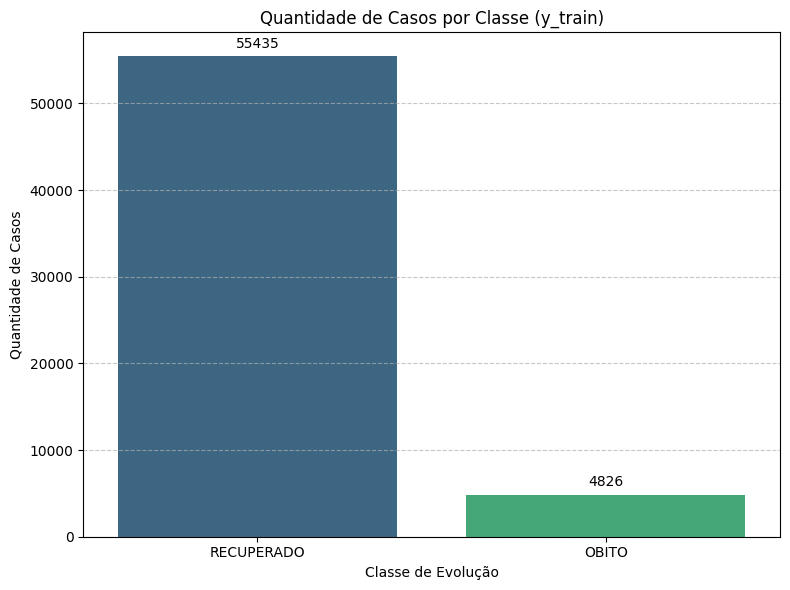

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_named, hue=y_train_named, order=y_train_named.value_counts().index, palette='viridis', legend=False)
plt.title('Quantidade de Casos por Classe (y_train)')
plt.xlabel('Classe de Evolução')
plt.ylabel('Quantidade de Casos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionando os rótulos de contagem em cima das barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

podemos ver que o dataset é bem desbalanceado

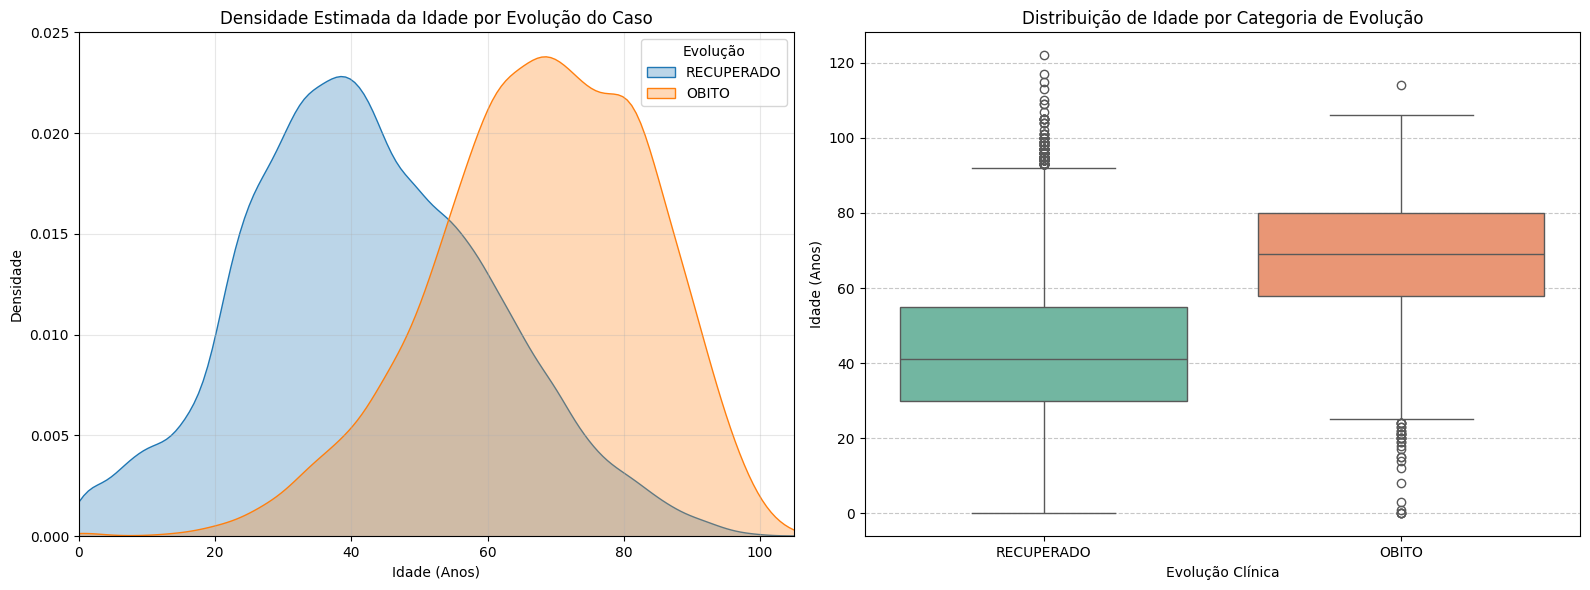

In [128]:


# Configurando a figura com 2 subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Criamos um DataFrame temporário apenas para o plot
df_plot = X_train.copy()
df_plot['evolucao'] = y_train_named

# --- Subplot 1: KDE Plot (Densidade) ---
for categoria in df_plot['evolucao'].unique():
    # Filtramos a idade apenas para a categoria atual
    subset = df_plot[df_plot['evolucao'] == categoria]

    # Usamos o seaborn para um KDE mais suave e preenchido
    sns.kdeplot(subset['idade'], label=categoria, fill=True, alpha=0.3, ax=axes[0])

axes[0].set_title("Densidade Estimada da Idade por Evolução do Caso")
axes[0].set_xlabel("Idade (Anos)")
axes[0].set_ylabel("Densidade")
axes[0].set_xlim(0, 105)
axes[0].legend(title="Evolução")
axes[0].grid(alpha=0.3)

# --- Subplot 2: Boxplot ---
# Adicionei hue='evolucao' e legend=False para evitar o Warning da nova versão do Seaborn
sns.boxplot(x='evolucao', y='idade', data=df_plot, hue='evolucao',
            palette='Set2', order=['RECUPERADO', 'OBITO'],
            legend=False, ax=axes[1])

axes[1].set_title("Distribuição de Idade por Categoria de Evolução")
axes[1].set_xlabel("Evolução Clínica")
axes[1].set_ylabel("Idade (Anos)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

podemos ver que a uma grande discrepancia quanto a variavel idade, a covid tende a ser fatal para pessoas mais velhas o que torna idade uma boa preditora

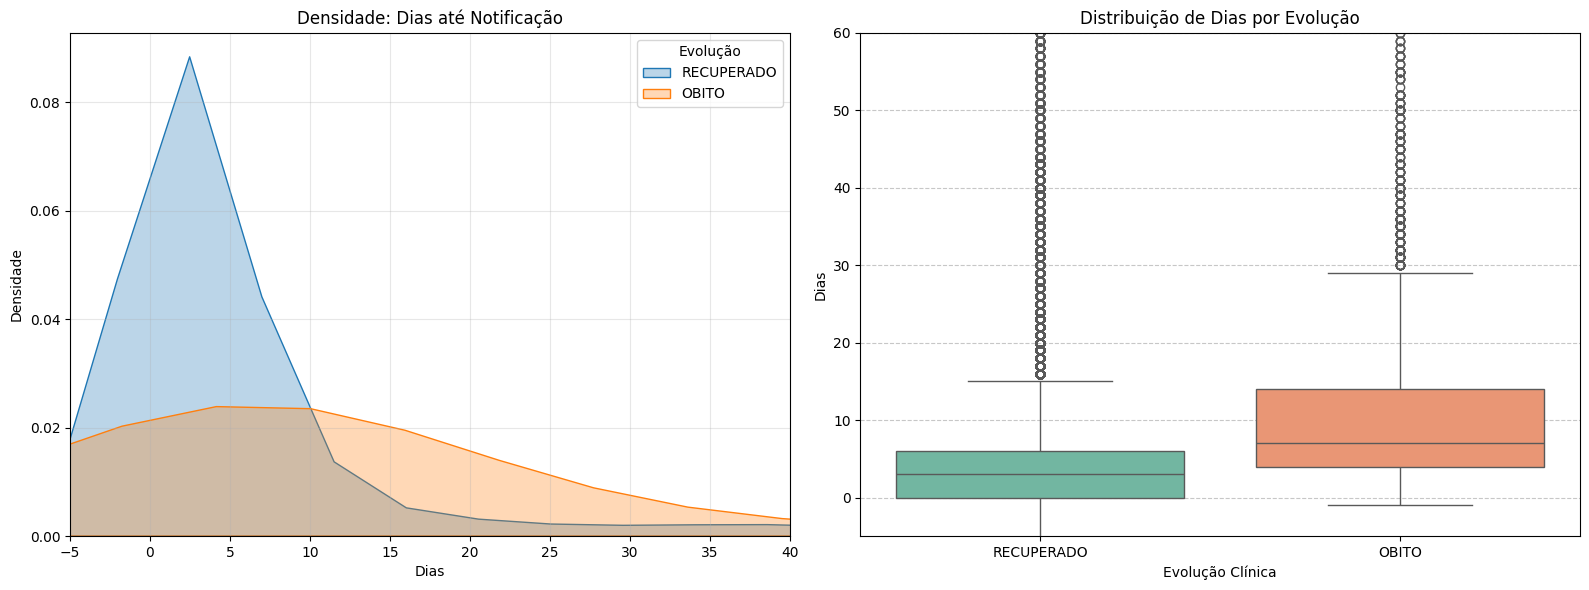

In [147]:
# Configurando a figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Criamos um DataFrame temporário
df_plot = X_train.copy()
df_plot['evolucao'] = y_train_named

# --- Subplot 1: KDE Plot (Densidade de Dias) ---
for categoria in df_plot['evolucao'].unique():
    subset = df_plot[df_plot['evolucao'] == categoria]
    sns.kdeplot(subset['dias_ate_notificar'], label=categoria, fill=True, alpha=0.3, ax=axes[0])

axes[0].set_title("Densidade: Dias até Notificação")
axes[0].set_xlabel("Dias")
axes[0].set_ylabel("Densidade")
axes[0].set_xlim(-5, 40) # Ajustado para focar no período mais comum
axes[0].legend(title="Evolução")
axes[0].grid(alpha=0.3)

# --- Subplot 2: Boxplot (Distribuição e Outliers) ---
sns.boxplot(
    x='evolucao',
    y='dias_ate_notificar',
    data=df_plot,
    hue='evolucao',
    palette='Set2',
    legend=False,
    ax=axes[1]
)

axes[1].set_title("Distribuição de Dias por Evolução")
axes[1].set_xlabel("Evolução Clínica")
axes[1].set_ylabel("Dias")
axes[1].set_ylim(-5, 60) # Limita o eixo Y para não achatar o boxplot com outliers extremos
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [148]:
df_final['dias_ate_notificar'].describe()

,dias_ate_notificar
count,75327.000000
mean,9.293467
std,30.980938
min,-364.000000
25%,0.000000
50%,3.000000
75%,7.000000
max,794.000000


apesar de bastante ruidosa e cheia de outliers, o gap de dias ainda possui informação util, desde que bem tratada

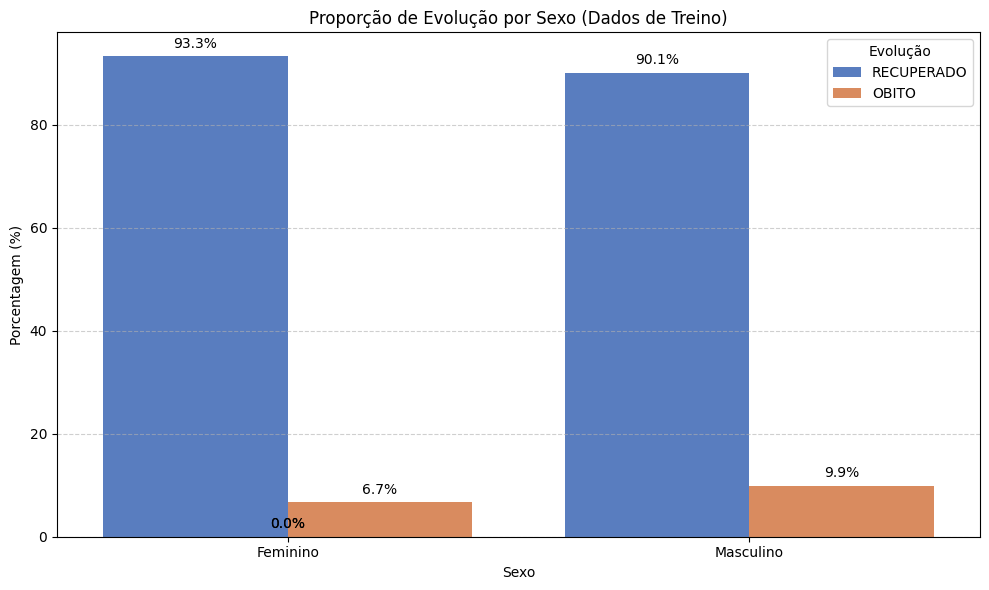

In [ ]:
df_plot = X_train.copy()
df_plot['evolucao'] = y_train_named

# Calculando as proporções para não ser enganado pelo volume de dados
# Isso mostra: "De 100 homens, quantos morreram?" vs "De 100 mulheres, quantas morreram?"
df_prop = df_plot.groupby('sexo')['evolucao'].value_counts(normalize=True).rename('proporcao').reset_index()
df_prop['proporcao'] *= 100 # Converter para porcentagem

# Plotando
plt.figure(figsize=(10, 6))
sns.barplot(data=df_prop, x='sexo', y='proporcao', hue='evolucao',
            hue_order=['RECUPERADO', 'OBITO'], palette='muted')

plt.title("Proporção de Evolução por Sexo (Dados de Treino)")
plt.xlabel("Sexo")
plt.ylabel("Porcentagem (%)")
plt.legend(title="Evolução")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionando os rótulos de porcentagem em cima das barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}%',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

Os dados mostram que os homens tem um chance um pouco maior de ir a óbito

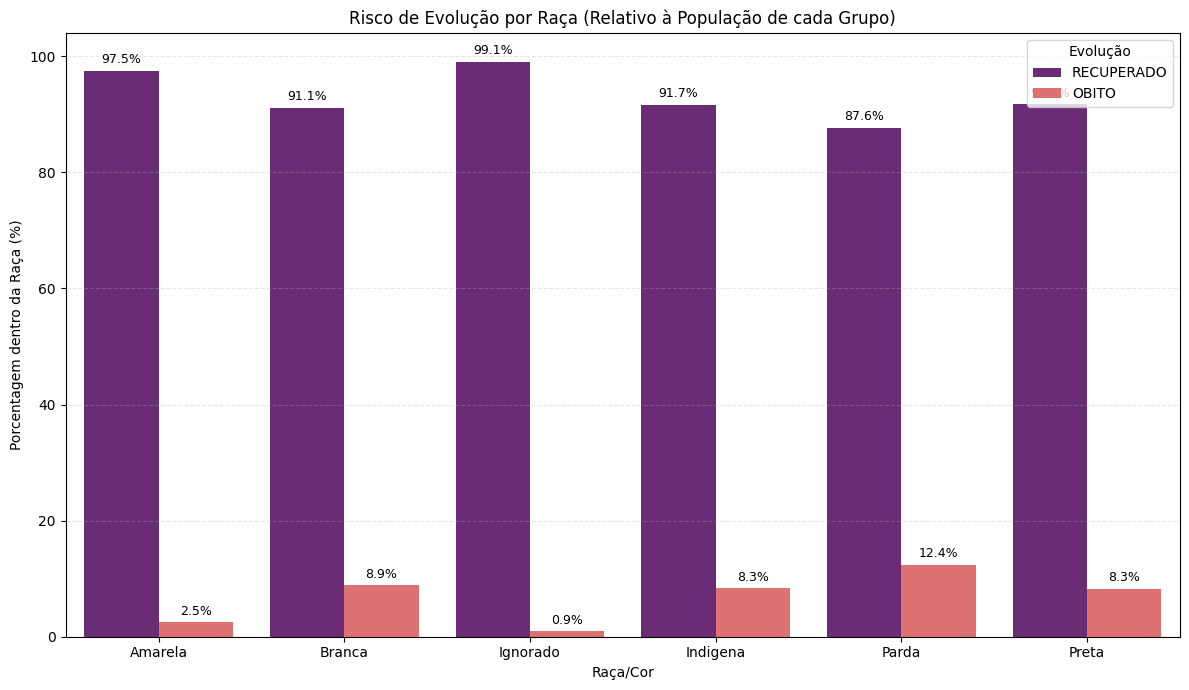

In [ ]:
df_plot_risco = X_train.copy()
df_plot_risco['evolucao'] = y_train_named

# 2. Calculando a porcentagem em relação à população total de CADA raça
# normalize=True dentro do groupby('raca') faz exatamente o que você pediu
df_risco_raca = df_plot_risco.groupby('raca')['evolucao'].value_counts(normalize=True).rename('pct').reset_index()
df_risco_raca['pct'] *= 100

# 3. Plotando
plt.figure(figsize=(12, 7))
sns.barplot(data=df_risco_raca, x='raca', y='pct', hue='evolucao',
            hue_order=['RECUPERADO', 'OBITO'], palette='magma')

plt.title("Risco de Evolução por Raça (Relativo à População de cada Grupo)")
plt.xlabel("Raça/Cor")
plt.ylabel("Porcentagem dentro da Raça (%)")
plt.legend(title="Evolução", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 4. Adicionando os rótulos de porcentagem
for p in plt.gca().patches:
    h = p.get_height()
    if h > 0:
        plt.gca().annotate(f'{h:.1f}%',
                           (p.get_x() + p.get_width() / 2., h),
                           ha='center', va='center',
                           xytext=(0, 8),
                           textcoords='offset points',
                           fontsize=9)

plt.tight_layout()
plt.show()

Parece haver alguma impacto de raça no desfecho final, para certificar será aplicado um teste estatistico, como as 2 vars são categoricas, foi aplicado qui-quadrado

In [ ]:
tabela_contingencia = pd.crosstab(y_train_named, X_train['raca'])

# 2. Executar o teste
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Estatística Chi2: {chi2:.2f}")
print(f"p-value: {p:.4e}") # Notação científica para p-values muito pequenos
print(f"Graus de Liberdade: {dof}")

# 3. Interpretação
alpha = 0.05
if p < alpha:
    print("\nConclusão: Rejeitamos a hipótese nula. Existe uma associação estatisticamente significativa entre Raça e Evolução.")
else:
    print("\nConclusão: Não há evidências de associação significativa.")

Estatística Chi2: 1646.61
p-value: 0.0000e+00
Graus de Liberdade: 5

Conclusão: Rejeitamos a hipótese nula. Existe uma associação estatisticamente significativa entre Raça e Evolução.


podemos confirmar que de fato a variavel raça impacta no desfecho

In [ ]:
# agora vamos testar estatitisticamente cada sintoma para ver se tem impacto no desfecho e ordenar por nivel de impacto
resultados_stats = []
sintomas_cols = [col for col in X_train.columns if col.startswith('sintoma_')]
for col in sintomas_cols:
    tabela = pd.crosstab(X_train[col], y_train_named)
    chi2, p, _, _ = chi2_contingency(tabela)
    resultados_stats.append({'Sintoma': col, 'p-value': p, 'Chi2': chi2})

df_stats = pd.DataFrame(resultados_stats).sort_values(by='Chi2', ascending=False)
print(df_stats)

                                              Sintoma        p-value  \
17                          sintoma_Saturação_O2_<_95   0.000000e+00   
4                                    sintoma_Dispneia   0.000000e+00   
13  sintoma_Desconforto_respiratório___aperto_torá...   0.000000e+00   
0                                      sintoma_Coriza   0.000000e+00   
2                               sintoma_Assintomático   0.000000e+00   
3                                       sintoma_Febre   0.000000e+00   
6                             sintoma_Dor_de_Garganta   0.000000e+00   
5                               sintoma_Dor_de_Cabeça   0.000000e+00   
11                             sintoma_Cansaço_fadiga  2.709270e-207   
19                                     sintoma_Vômito  3.028390e-150   
14                                   sintoma_Diarreia  1.193016e-146   
1                                       sintoma_Tosse   8.885782e-97   
15                                    sintoma_Mialgia   1.043619

podemos ver que praticamente todos os sintomas influenciam no resultado, e os que mais impactaram, são os que o ministerio da saúde orienta a prestar mais atenção

/tmp/ipython-input-1869951661.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_letalidade, x='Taxa de Óbito (%)', y='Sintoma', palette='Reds_r')


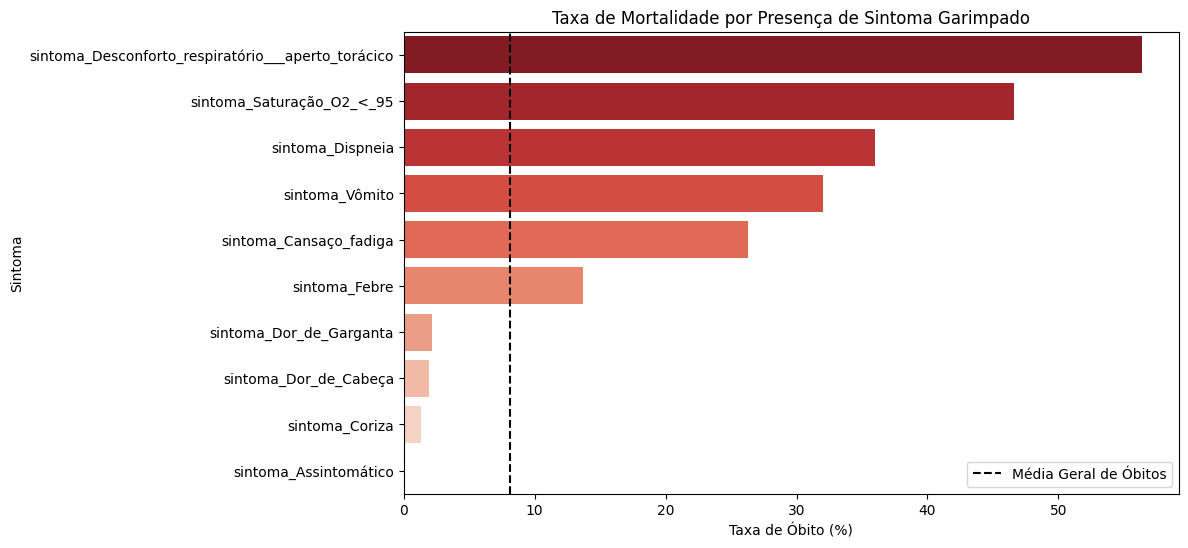

In [ ]:
# Calculando a taxa de óbito para o Top 10 sintomas
top_10_sintomas = df_stats.head(10)['Sintoma'].tolist()
letalidade = []

for s in top_10_sintomas:
    # Filtra apenas quem tem o sintoma (valor 1)
    portadores = df_final[df_final[s] == 1]
    if len(portadores) > 0:
        taxa = (portadores[portadores['evolucao'] == 'OBITO'].shape[0] / len(portadores)) * 100
        letalidade.append({'Sintoma': s, 'Taxa de Óbito (%)': taxa})

df_letalidade = pd.DataFrame(letalidade).sort_values('Taxa de Óbito (%)', ascending=False)

# Plotando
plt.figure(figsize=(10, 6))
sns.barplot(data=df_letalidade, x='Taxa de Óbito (%)', y='Sintoma', palette='Reds_r')
plt.title("Taxa de Mortalidade por Presença de Sintoma Garimpado")
plt.axvline(8.1, color='black', linestyle='--', label='Média Geral de Óbitos') # 8.1% é a média do seu dataset
plt.legend()
plt.show()

novamente os dados confirmam os sintomas mais criticos, reafirmando que as recomendações do ministerio da saúde foram adequadas. Também é valido destacar que para o caso de  assintomáticos a taxa de letalidade foi de 0% o que indica que a aqueles com ausência de sintomas não precisam ser priorizados

/tmp/ipython-input-1130370940.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_let, x='Taxa_Obito', y='Sintoma', palette=colors)


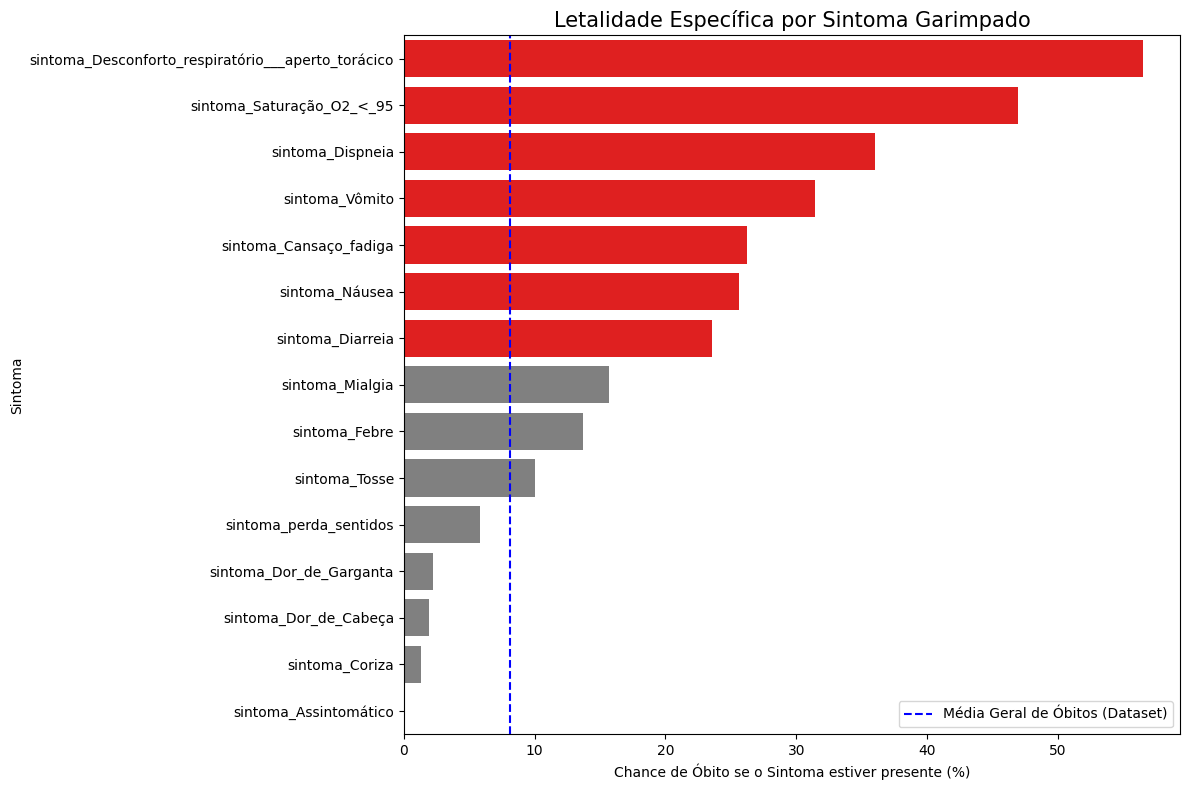

In [ ]:
# avaliando todos os sintomas
# Preparando os dados de letalidade (Taxa de Óbito por Sintoma)
letalidade_dict = {}
for s in sintomas_cols:
    subset = X_train[X_train[s] == 1]
    if len(subset) > 50: # Filtro para evitar sintomas raros que distorcem a estatística
        taxa = (y_train[subset.index] == 'OBITO').mean() * 100
        letalidade_dict[s] = taxa

df_let = pd.DataFrame(list(letalidade_dict.items()), columns=['Sintoma', 'Taxa_Obito'])
df_let = df_let.sort_values('Taxa_Obito', ascending=False)

# Plotando
plt.figure(figsize=(12, 8))
colors = ['red' if x > 20 else 'grey' for x in df_let['Taxa_Obito']]
sns.barplot(data=df_let, x='Taxa_Obito', y='Sintoma', palette=colors)

# Linha da média geral de óbitos no dataset (~8.1%)
plt.axvline(8.1, color='blue', linestyle='--', label='Média Geral de Óbitos (Dataset)')

plt.title("Letalidade Específica por Sintoma Garimpado", fontsize=15)
plt.xlabel("Chance de Óbito se o Sintoma estiver presente (%)")
plt.legend()
plt.tight_layout()
plt.show()

# Modelagem

tratamento da variavel de dias_ate_notificar

In [161]:
# 1. clipping do valor contínuo (preserva sinal útil)
X_train['dias_ate_notificar_clip'] = (
    X_train['dias_ate_notificar']
    .clip(lower=-1, upper=60)
)

# 2. definição dos bins (baseados na sua distribuição)
bins = [-np.inf, -1, 0, 2, 5, 10, 20, 60, np.inf]
labels = [
    'erro',
    'mesmo_dia',
    '1_2',
    '3_5',
    '6_10',
    '11_20',
    '21_60',
    '60_mais'
]

X_train['dias_ate_notificar_bin'] = pd.cut(
    X_train['dias_ate_notificar'],
    bins=bins,
    labels=labels,
    ordered=True
)
X_train.drop(columns=['dias_ate_notificar','dias_ate_notificar_clip'], inplace=True)

In [193]:
# 1. Aplicar o Clipping no X_test
X_test['dias_ate_notificar_clip'] = (
    X_test['dias_ate_notificar']
    .clip(lower=-1, upper=60)
)

# 2. Aplicar o Binning (usando os mesmos bins e labels do treino)
X_test['dias_ate_notificar_bin'] = pd.cut(
    X_test['dias_ate_notificar'],
    bins=[-np.inf, -1, 0, 2, 5, 10, 20, 60, np.inf],
    labels=[
        'erro',
        'mesmo_dia',
        '1_2',
        '3_5',
        '6_10',
        '11_20',
        '21_60',
        '60_mais'
    ],
    ordered=True
)

# 3. Remover as colunas originais e auxiliares para deixar o X_test idêntico ao X_train
X_test.drop(columns=['dias_ate_notificar', 'dias_ate_notificar_clip'], inplace=True)

Serão comparados 2 modelos, Random Forest e XGBoost, para cada um serão feitos 2 experimentos, um tentando otimizar para recall e outro para f1-score, utilizando optuna

## Random forest

para lidar com o desbalancemento, foi alterado o parametro classifier__class_weight no optuna para testar 2 valores para balancear o treino e decidir qual o melhor

In [162]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [164]:
def objective_rf_f1(trial):
    # 1. Sugestão de Hiperparâmetros
    param = {
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 500),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 20),
        'classifier__min_samples_split': trial.suggest_int('classifier__min_samples_split', 2, 10),
        'classifier__min_samples_leaf': trial.suggest_int('classifier__min_samples_leaf', 1, 10),
        'classifier__class_weight': trial.suggest_categorical('classifier__class_weight', ['balanced', 'balanced_subsample', None])
    }

    # 2. Configurar o Pipeline com os novos parâmetros
    pipeline.set_params(**param)

    # 3. Validação Cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

    return score.mean()

def objective_rf_rec(trial):
    # 1. Sugestão de Hiperparâmetros
    # Use o prefixo 'classifier__' para o Optuna saber que esses parâmetros são do Random Forest
    param = {
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 500),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 20),
        'classifier__min_samples_split': trial.suggest_int('classifier__min_samples_split', 2, 10),
        'classifier__min_samples_leaf': trial.suggest_int('classifier__min_samples_leaf', 1, 10),
        'classifier__class_weight': trial.suggest_categorical('classifier__class_weight', ['balanced', 'balanced_subsample', None])
    }

    # 2. Configurar o Pipeline com os novos parâmetros
    # O pipeline já foi definido anteriormente (como você postou)
    pipeline.set_params(**param)

    # 3. Validação Cruzada
    # Usamos o Recall como métrica principal devido à natureza do seu projeto (COVID)
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)

    return score.mean()

In [166]:
sampler_f1 = optuna.samplers.TPESampler(seed=42)
study_rf_f1 = optuna.create_study(direction='maximize', sampler=sampler_f1)
study_rf_f1.optimize(objective_rf_f1, n_trials=30)

print(f"Melhores parâmetros: {study_rf_f1.best_params}")

[I 2026-02-10 20:07:27,896] A new study created in memory with name: no-name-640082b6-2f9e-4404-ae49-3f05e00bf0f0
[I 2026-02-10 20:08:08,330] Trial 0 finished with value: 0.7050654012093684 and parameters: {'classifier__n_estimators': 250, 'classifier__max_depth': 20, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 6, 'classifier__class_weight': 'balanced'}. Best is trial 0 with value: 0.7050654012093684.
[I 2026-02-10 20:09:23,011] Trial 1 finished with value: 0.712793063124229 and parameters: {'classifier__n_estimators': 447, 'classifier__max_depth': 13, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 1, 'classifier__class_weight': 'balanced'}. Best is trial 1 with value: 0.712793063124229.
[I 2026-02-10 20:09:40,964] Trial 2 finished with value: 0.5881415750638761 and parameters: {'classifier__n_estimators': 172, 'classifier__max_depth': 6, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 6, 'classifier__class_weight': None}

Melhores parâmetros: {'classifier__n_estimators': 362, 'classifier__max_depth': 19, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 1, 'classifier__class_weight': 'balanced_subsample'}


### RELATÓRIO: RANDOM FOREST (OTIMIZADO PARA F1-SCORE) ###
              precision    recall  f1-score   support

  RECUPERADO       0.99      0.95      0.97     55435
       OBITO       0.62      0.88      0.73      4826

    accuracy                           0.95     60261
   macro avg       0.81      0.92      0.85     60261
weighted avg       0.96      0.95      0.95     60261



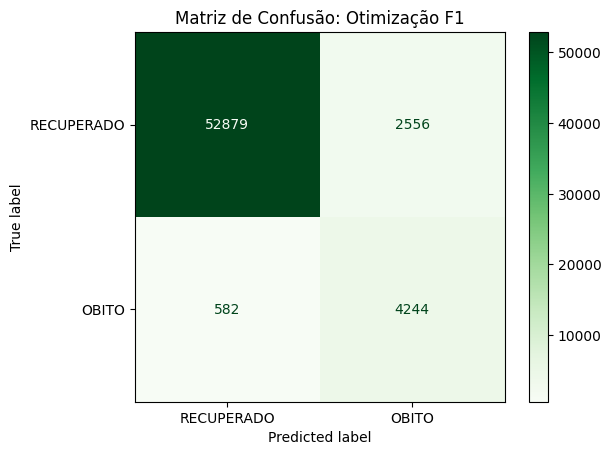

In [168]:
# --- MODELO 1: F1-SCORE ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipeline.set_params(**study_rf_f1.best_params)
y_pred_f1 = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

print("### RELATÓRIO: RANDOM FOREST (OTIMIZADO PARA F1-SCORE) ###")
print(classification_report(y_train, y_pred_f1, target_names=['RECUPERADO', 'OBITO']))

# Matriz F1
cm_f1 = confusion_matrix(y_train, y_pred_f1)
disp_f1 = ConfusionMatrixDisplay(confusion_matrix=cm_f1, display_labels=['RECUPERADO', 'OBITO'])
disp_f1.plot(cmap='Greens')
plt.title('Matriz de Confusão: Otimização F1')
plt.show()

Podemos ver que o modelo atingiu boa performance para a classe majoritaria. Já a classe minoritaria, tem um bom recall e uma precisão um pouco baixa, o que indica que o modelo está preferindo "pecar pelo excesso" na classe minoritaria, ou seja, "na duvida, classifica como obito"

In [169]:
sampler_rec = optuna.samplers.TPESampler(seed=42)
study_rf_rec = optuna.create_study(direction='maximize', sampler=sampler_rec)
study_rf_rec.optimize(objective_rf_rec, n_trials=30)

print(f"Melhores parâmetros: {study_rf_rec.best_params}")

[I 2026-02-10 20:43:26,716] A new study created in memory with name: no-name-d1619134-1ab9-449b-840b-51550a3d6655
[I 2026-02-10 20:44:33,857] Trial 0 finished with value: 0.9432240208541177 and parameters: {'classifier__n_estimators': 250, 'classifier__max_depth': 20, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 6, 'classifier__class_weight': 'balanced'}. Best is trial 0 with value: 0.9432240208541177.
[I 2026-02-10 20:45:34,636] Trial 1 finished with value: 0.9280983490490137 and parameters: {'classifier__n_estimators': 447, 'classifier__max_depth': 13, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 1, 'classifier__class_weight': 'balanced'}. Best is trial 0 with value: 0.9432240208541177.
[I 2026-02-10 20:45:53,642] Trial 2 finished with value: 0.47286154110213585 and parameters: {'classifier__n_estimators': 172, 'classifier__max_depth': 6, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 6, 'classifier__class_weight': No

Melhores parâmetros: {'classifier__n_estimators': 109, 'classifier__max_depth': 5, 'classifier__min_samples_split': 7, 'classifier__min_samples_leaf': 9, 'classifier__class_weight': 'balanced'}


### RELATÓRIO: RANDOM FOREST (OTIMIZADO PARA RECALL) ###
              precision    recall  f1-score   support

  RECUPERADO       1.00      0.90      0.95     55435
       OBITO       0.47      0.96      0.63      4826

    accuracy                           0.91     60261
   macro avg       0.73      0.93      0.79     60261
weighted avg       0.95      0.91      0.92     60261



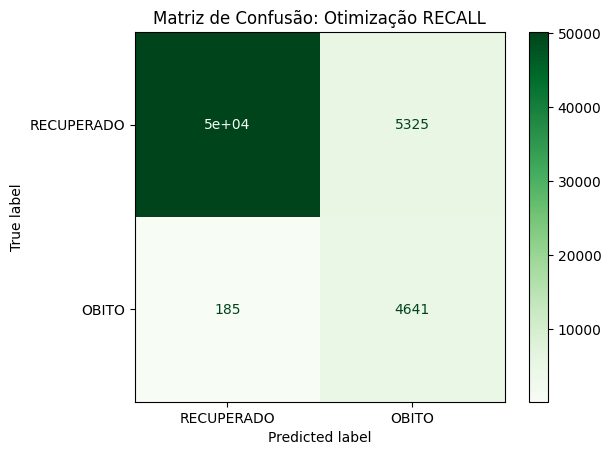

In [171]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipeline.set_params(**study_rf_rec.best_params)
y_pred_rec = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

print("### RELATÓRIO: RANDOM FOREST (OTIMIZADO PARA RECALL) ###")
print(classification_report(y_train, y_pred_rec, target_names=['RECUPERADO', 'OBITO']))

# Matriz F1
cm_rec = confusion_matrix(y_train, y_pred_rec)
disp_f1 = ConfusionMatrixDisplay(confusion_matrix=cm_rec, display_labels=['RECUPERADO', 'OBITO'])
disp_f1.plot(cmap='Greens')
plt.title('Matriz de Confusão: Otimização RECALL')
plt.show()

o estudo focado em melhorar recall, de fato melhorou a metrica, porem a precisão piorou, como era esperado

/tmp/ipython-input-3233902638.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=df_importancia.head(15), palette='viridis')


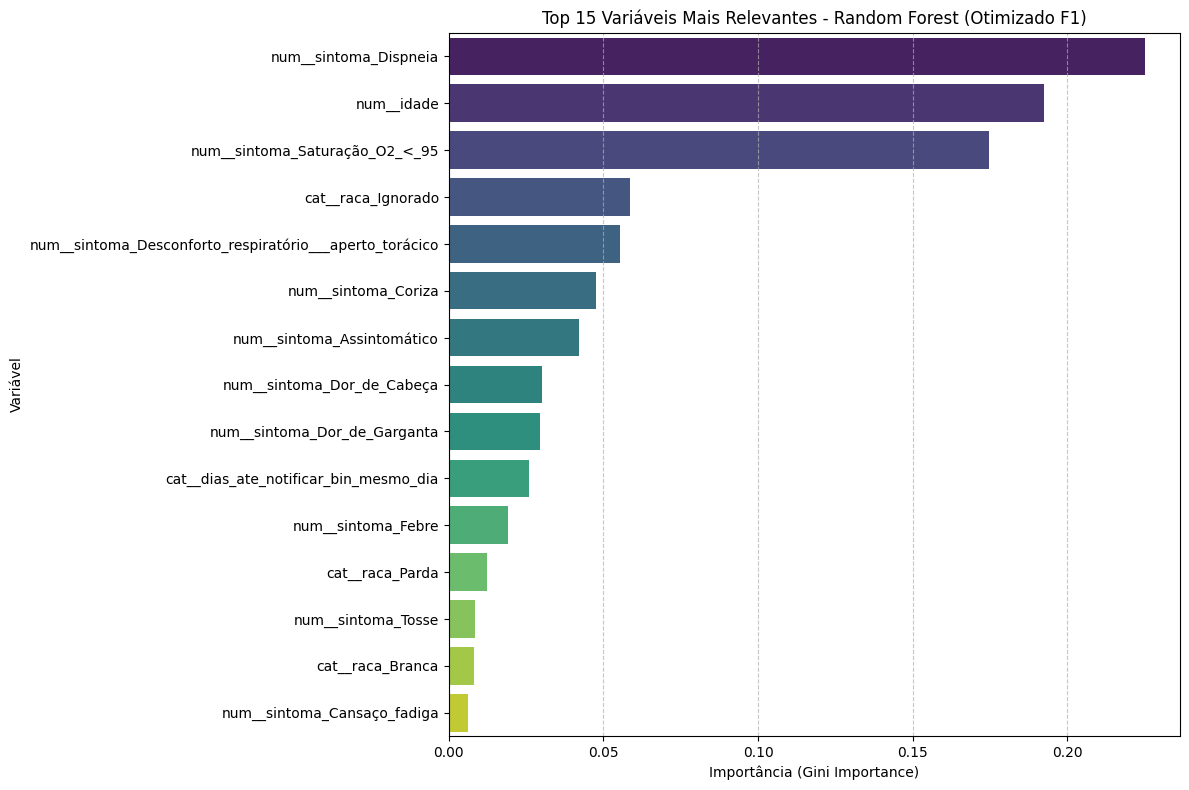

In [172]:
melhores_params = study_rf_f1.best_params

# 2. Atualiza o pipeline e treina com os dados completos de treino
pipeline.set_params(**melhores_params)
pipeline.fit(X_train, y_train)

# 3. Pegar os nomes das colunas após o pré-processamento
# (Importante para ver os nomes corretos do OneHot e das variáveis de atraso/bin)
features_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# 4. Pegar as importâncias do classificador
importancias = pipeline.named_steps['classifier'].feature_importances_

# 5. Criar um DataFrame para organizar
df_importancia = pd.DataFrame({
    'Feature': features_names,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# 6. Plotar as Top 15
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Feature', data=df_importancia.head(15), palette='viridis')

plt.title('Top 15 Variáveis Mais Relevantes - Random Forest (Otimizado F1)')
plt.xlabel('Importância (Gini Importance)')
plt.ylabel('Variável')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

aqui podemos ver que as variaveis principais são as esperadas, os sintomas mais graves, a idade e, surpreendentemente, raça_ignorado, o que corrobora o fato de a ausencia de valores nessa várivel carregar informações úteis

## XGBOOST

In [173]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [184]:
def objective_xgb_f1(trial):
    # Cálculo do ratio para lidar com o desbalanceamento (Óbitos são minoria)
    counts = y_train.value_counts()
    ratio = counts[0] / counts[1]

    param = {
        # Profundidade e número de árvores
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 800),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 10),
        'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.2, log=True),

        # Parâmetro crucial para o seu Recall/F1 em dados desbalanceados
        'classifier__scale_pos_weight': trial.suggest_float('classifier__scale_pos_weight', 1, ratio * 1.5),

        # Regularização (Evita que o modelo "decore" os dados)
        'classifier__subsample': trial.suggest_float('classifier__subsample', 0.6, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.6, 1.0),
        'classifier__gamma': trial.suggest_float('classifier__gamma', 0, 5),
    }

    # Aplicamos os parâmetros sugeridos
    pipeline_xgb.set_params(**param)

    # Validação Cruzada (Usando o skf que definimos com shuffle)
    score = cross_val_score(pipeline_xgb, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)

    return score.mean()
def objective_xgb_rec(trial):
    # Cálculo do ratio para lidar com o desbalanceamento (Óbitos são minoria)
    counts = y_train.value_counts()
    ratio = counts[0] / counts[1]

    param = {
        # Profundidade e número de árvores
        'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 800),
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 10),
        'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.2, log=True),

        # Parâmetro crucial para o seu Recall/F1 em dados desbalanceados
        'classifier__scale_pos_weight': trial.suggest_float('classifier__scale_pos_weight', 1, ratio * 1.5),

        # Regularização (Evita que o modelo "decore" os dados)
        'classifier__subsample': trial.suggest_float('classifier__subsample', 0.6, 1.0),
        'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.6, 1.0),
        'classifier__gamma': trial.suggest_float('classifier__gamma', 0, 5),
    }

    # Aplicamos os parâmetros sugeridos
    pipeline_xgb.set_params(**param)

    # Validação Cruzada (Usando o skf que definimos com shuffle)
    score = cross_val_score(pipeline_xgb, X_train, y_train, cv=skf, scoring='recall', n_jobs=-1)

    return score.mean()


In [180]:
study_xgb_f1 = optuna.create_study(direction='maximize')
study_xgb_f1.optimize(objective_xgb_f1, n_trials=50)
print(study_rf_f1.best_params)

[I 2026-02-10 21:16:31,357] A new study created in memory with name: no-name-7711f164-13b7-41df-bf7f-1229a5883a5d
[I 2026-02-10 21:16:48,188] Trial 0 finished with value: 0.7096096497411006 and parameters: {'classifier__n_estimators': 262, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.04210936665602001, 'classifier__scale_pos_weight': 7.383628356195351, 'classifier__subsample': 0.7418173227304656, 'classifier__colsample_bytree': 0.7824397910633747, 'classifier__gamma': 0.31853337073193266}. Best is trial 0 with value: 0.7096096497411006.
[I 2026-02-10 21:17:15,174] Trial 1 finished with value: 0.7048655413584577 and parameters: {'classifier__n_estimators': 473, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.013762527415146036, 'classifier__scale_pos_weight': 11.772055179292892, 'classifier__subsample': 0.7316204627366629, 'classifier__colsample_bytree': 0.6175936142183875, 'classifier__gamma': 1.1828197874646356}. Best is trial 0 with value: 0.7096096497411006.

{'classifier__n_estimators': 362, 'classifier__max_depth': 19, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 1, 'classifier__class_weight': 'balanced_subsample'}


### RELATÓRIO FINAL: XGBOOST (OTIMIZADO PARA F1-SCORE) ###
              precision    recall  f1-score   support

  RECUPERADO       0.99      0.96      0.97     55435
       OBITO       0.66      0.83      0.74      4826

    accuracy                           0.95     60261
   macro avg       0.82      0.90      0.86     60261
weighted avg       0.96      0.95      0.96     60261



<Figure size 800x600 with 0 Axes>

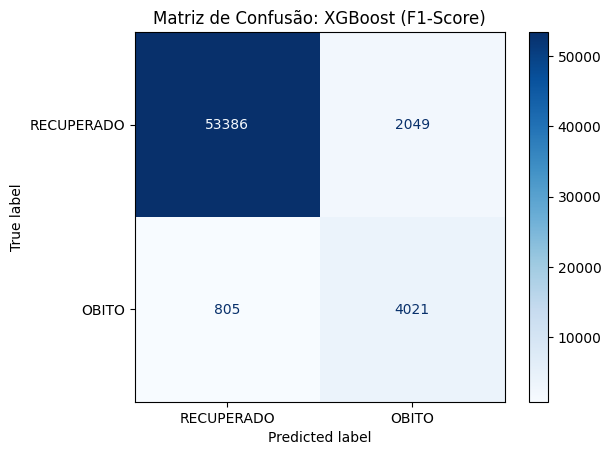

In [182]:
pipeline_xgb.set_params(**study_xgb_f1.best_params)

# 2. Gerar predições via Cross-Validation (usando o mesmo skf com shuffle)
# O cross_val_predict garante que estamos avaliando a generalização
y_pred_xgb_f1 = cross_val_predict(pipeline_xgb, X_train, y_train, cv=skf, n_jobs=-1)

# 3. Print do Relatório
print("### RELATÓRIO FINAL: XGBOOST (OTIMIZADO PARA F1-SCORE) ###")
print(classification_report(y_train, y_pred_xgb_f1, target_names=['RECUPERADO', 'OBITO']))

# 4. Plot da Matriz de Confusão
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_train, y_pred_xgb_f1)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['RECUPERADO', 'OBITO'])
disp_xgb.plot(cmap='Blues', values_format='d') # Mudei para Plasma para diferenciar do RF
plt.title('Matriz de Confusão: XGBoost (F1-Score)')
plt.show()

Um pouco mais balanceado que o estudo de random forest para otimizar f1, comparado a ele, a classe minoritaria perdeu um pouco de recall e ganhou um pouco de precisão

In [185]:
study_xgb_rec = optuna.create_study(direction='maximize')
study_xgb_rec.optimize(objective_xgb_rec, n_trials=50)
print(study_rf_rec.best_params)

[I 2026-02-10 21:48:29,422] A new study created in memory with name: no-name-6fe2c7ed-d763-4152-bbb4-a4dba1600406
[I 2026-02-10 21:48:54,444] Trial 0 finished with value: 0.8941162209420825 and parameters: {'classifier__n_estimators': 454, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.03157387666230007, 'classifier__scale_pos_weight': 3.1850267697272487, 'classifier__subsample': 0.979022653766678, 'classifier__colsample_bytree': 0.9224898768993167, 'classifier__gamma': 4.143848299427243}. Best is trial 0 with value: 0.8941162209420825.
[I 2026-02-10 21:49:13,071] Trial 1 finished with value: 0.9556592540147394 and parameters: {'classifier__n_estimators': 742, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.02478114252354481, 'classifier__scale_pos_weight': 13.495448736610133, 'classifier__subsample': 0.9307710469454601, 'classifier__colsample_bytree': 0.9031313082927979, 'classifier__gamma': 4.229666208705583}. Best is trial 1 with value: 0.9556592540147394.
[I

{'classifier__n_estimators': 109, 'classifier__max_depth': 5, 'classifier__min_samples_split': 7, 'classifier__min_samples_leaf': 9, 'classifier__class_weight': 'balanced'}


### RELATÓRIO FINAL: XGBOOST (OTIMIZADO PARA F1-RECALL) ###
              precision    recall  f1-score   support

  RECUPERADO       1.00      0.92      0.96     55435
       OBITO       0.51      0.96      0.66      4826

    accuracy                           0.92     60261
   macro avg       0.75      0.94      0.81     60261
weighted avg       0.96      0.92      0.93     60261



<Figure size 800x600 with 0 Axes>

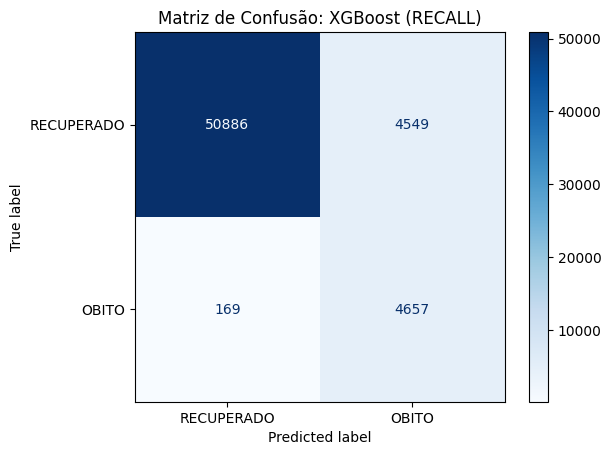

In [187]:
pipeline_xgb.set_params(**study_xgb_rec.best_params)

# 2. Gerar predições via Cross-Validation (usando o mesmo skf com shuffle)
# O cross_val_predict garante que estamos avaliando a generalização
y_pred_xgb_rec = cross_val_predict(pipeline_xgb, X_train, y_train, cv=skf, n_jobs=-1)

# 3. Print do Relatório
print("### RELATÓRIO FINAL: XGBOOST (OTIMIZADO PARA F1-RECALL) ###")
print(classification_report(y_train, y_pred_xgb_rec, target_names=['RECUPERADO', 'OBITO']))

# 4. Plot da Matriz de Confusão
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_train, y_pred_xgb_rec)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['RECUPERADO', 'OBITO'])
disp_xgb.plot(cmap='Blues', values_format='d') # Mudei para Plasma para diferenciar do RF
plt.title('Matriz de Confusão: XGBoost (RECALL)')
plt.show()

Comparado ao estudo para melhorar recall com random forest, esse experimento teve melhor performance na classe minoritaria, trocando um pouco do recall da classe majoritaria

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-103288347.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp.head(12), palette='rocket')


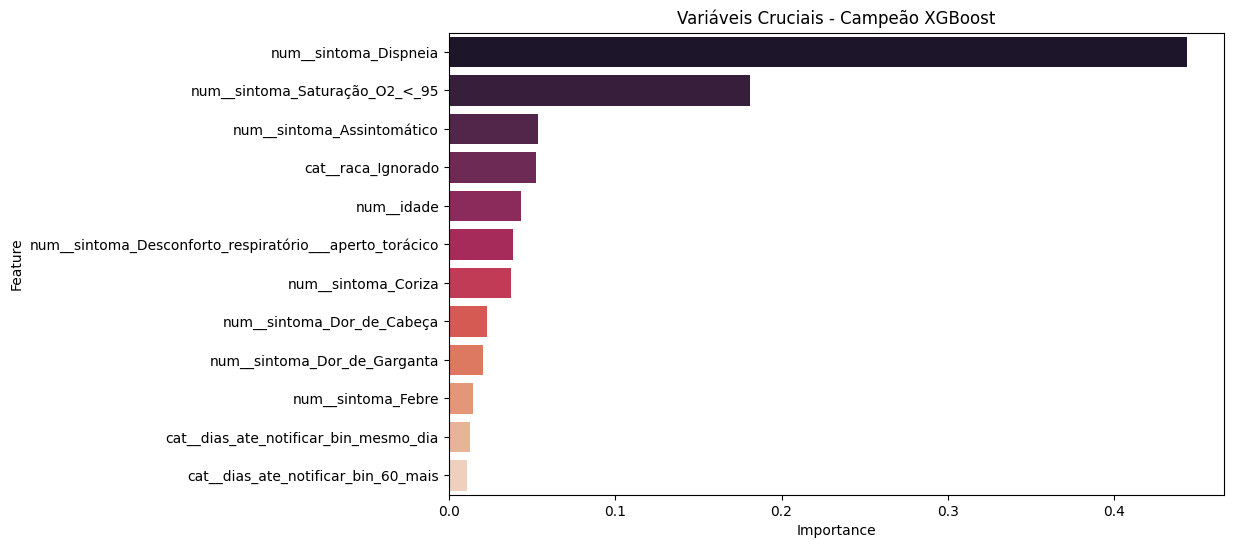

In [188]:
# 1. Treinar o modelo final
pipeline_xgb.set_params(**study_xgb_rec.best_params)
pipeline_xgb.fit(X_train, y_train)

# 2. Extrair importâncias
features = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline_xgb.named_steps['classifier'].feature_importances_

df_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# 3. Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp.head(12), palette='rocket')
plt.title('Variáveis Cruciais - Campeão XGBoost')
plt.show()

As features principais são os sintomas mais graves e também 'sintoma_assintomatico' o que pode ser explicado pelo fato de casos assintomaticos terem 0% de obitos. idade e as features de tempo em dias serem usadas, era esperado, a surpresa é o 'cat_raca_ignorado'

In [191]:
pipeline_xgb.set_params(**study_xgb_rec.best_params) # ou o nome do seu estudo de recall

# 2. Treina com 100% dos dados de treino antes de salvar
pipeline_xgb.fit(X_train, y_train)

# 3. Salva o arquivo
joblib.dump(pipeline_xgb, 'modelo_vida_covid_recife_xgb.pkl')

print("Modelo Campeão Salvo com Sucesso!")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo Campeão Salvo com Sucesso!


# Conclusões

1. Superioridade Algorítmica

   "O XGBoost demonstrou maior capacidade de aprendizado sequencial (boosting), se mostrando mais balanceado que o Random Forest em ambos os cenários."

2. O Dilema Ético e Decisão Técnica

   "A escolha pelo modelo otimizado para Recall (96%) fundamenta-se no princípio da precaução em saúde pública. Em uma pandemia, o custo humano de um falso negativo (um óbito não previsto) é infinitamente superior ao custo operacional de um falso positivo (triagem preventiva de um paciente que se recuperaria)."

3. Qualidade de Dados (O famoso "Garbage In, Garbage Out")

   "Identificou-se que a ausência de dados estruturados sobre comorbidades é o principal limitador do teto de performance do modelo. Melhorias na coleta desses dados permitiriam aumentar a precisão sem sacrificar a sensibilidade atual."

4. O Papel do Especialista

   "Este estudo seguiu as diretrizes oficiais do Ministério da Saúde para SRAG (2025). No entanto, ressalta-se que a validação final de um modelo clínico deve ser feita em conjunto com especialistas do domínio (médicos e epidemiologistas) para garantir a plausibilidade biológica das correlações encontradas."

### RELATÓRIO FINAL DE TESTE (DADOS NÃO VISTOS) ###
              precision    recall  f1-score   support

  RECUPERADO       1.00      0.92      0.96     13860
       OBITO       0.52      0.96      0.67      1206

    accuracy                           0.92     15066
   macro avg       0.76      0.94      0.82     15066
weighted avg       0.96      0.92      0.93     15066



<Figure size 800x600 with 0 Axes>

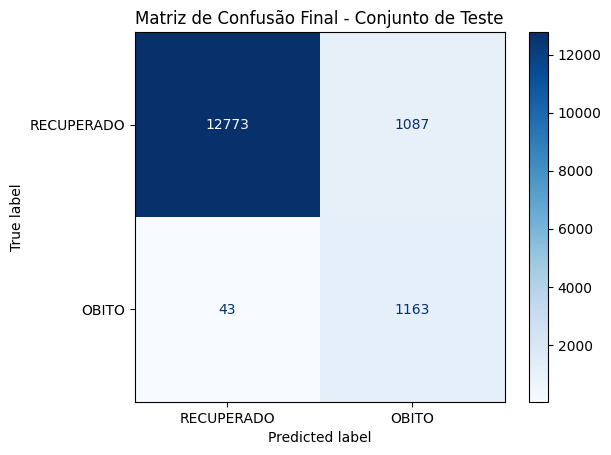

In [194]:
# 1. Gerar predições usando o conjunto de TESTE (X_test)
# O modelo já deve estar treinado (fit) com os melhores parâmetros antes disso
y_pred_final = pipeline_xgb.predict(X_test)

# 2. Relatório de Classificação (Comparando y_test com a predição)
print("### RELATÓRIO FINAL DE TESTE (DADOS NÃO VISTOS) ###")
print(classification_report(y_test, y_pred_final, target_names=['RECUPERADO', 'OBITO']))

# 3. Matriz de Confusão do Teste
plt.figure(figsize=(8, 6))
cm_final = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['RECUPERADO', 'OBITO'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão Final - Conjunto de Teste')
plt.show()